In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools
%matplotlib inline

In [2]:
movie_data = pd.read_csv('IMDB-Movie-Data.csv')
movie_data.Genre = movie_data.Genre.str.split(',')
movie_data.Actors = movie_data.Actors.str.split(', |,')
# movie_data = movie_data.nlargest(100, 'Revenue (Millions)')
movie_data

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"[Action, Adventure, Sci-Fi]",A group of intergalactic criminals are forced ...,James Gunn,"[Chris Pratt, Vin Diesel, Bradley Cooper, Zoe ...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"[Adventure, Mystery, Sci-Fi]","Following clues to the origin of mankind, a te...",Ridley Scott,"[Noomi Rapace, Logan Marshall-Green, Michael F...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"[Horror, Thriller]",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"[James McAvoy, Anya Taylor-Joy, Haley Lu Richa...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"[Animation, Comedy, Family]","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"[Matthew McConaughey, Reese Witherspoon, Seth ...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"[Action, Adventure, Fantasy]",A secret government agency recruits some of th...,David Ayer,"[Will Smith, Jared Leto, Margot Robbie, Viola ...",2016,123,6.2,393727,325.02,40.0
5,6,The Great Wall,"[Action, Adventure, Fantasy]",European mercenaries searching for black powde...,Yimou Zhang,"[Matt Damon, Tian Jing, Willem Dafoe, Andy Lau]",2016,103,6.1,56036,45.13,42.0
6,7,La La Land,"[Comedy, Drama, Music]",A jazz pianist falls for an aspiring actress i...,Damien Chazelle,"[Ryan Gosling, Emma Stone, Rosemarie DeWitt, J...",2016,128,8.3,258682,151.06,93.0
7,8,Mindhorn,[Comedy],A has-been actor best known for playing the ti...,Sean Foley,"[Essie Davis, Andrea Riseborough, Julian Barra...",2016,89,6.4,2490,NaN,71.0
8,9,The Lost City of Z,"[Action, Adventure, Biography]","A true-life drama, centering on British explor...",James Gray,"[Charlie Hunnam, Robert Pattinson, Sienna Mill...",2016,141,7.1,7188,8.01,78.0
9,10,Passengers,"[Adventure, Drama, Romance]",A spacecraft traveling to a distant colony pla...,Morten Tyldum,"[Jennifer Lawrence, Chris Pratt, Michael Sheen...",2016,116,7.0,192177,100.01,41.0


In [3]:
actors = set([actor for actors in movie_data.Actors.tolist() for actor in actors])
actors_temp = {}
for actor in actors:
    mask = movie_data.Actors.apply(lambda x: actor in x)
    movies = movie_data[mask]
    actors_temp[actor] = movies
actors = actors_temp

actor_relation = np.zeros(shape=(len(actors), len(actors)))
actor2int = dict(zip(actors.keys(), itertools.count()))

for i, row in movie_data.iterrows():
    for actor in [actor2int[x] for x in row.Actors]:
        for co_actor in [actor2int[x] for x in row.Actors]:
            if actor != co_actor: # avoid loops
                actor_relation[actor][co_actor] += 1

In [4]:
genres = set([genre for genres in movie_data.Genre.tolist() for genre in genres])

genre_relation = np.zeros(shape=(len(genres), len(genres)))
genre2int = dict(zip(genres, itertools.count()))

genre_counts = {}
for genre in genres:
    genre_counts[genre] = 0

for _, row in movie_data.iterrows():
    for genre in row.Genre:
        genre_counts[genre] += 1        
        genre1 = genre2int[genre]
        for genre2 in [genre2int[x] for x in row.Genre]:
            if genre1 != genre2: # avoid loops
                genre_relation[genre1][genre2] += 1

In [5]:
movie_relation = np.zeros(shape=(movie_data.shape[0], movie_data.shape[0]))
movie2int = dict(zip(list(movie_data['Title']), itertools.count()))

for actor, movies in actors.items():
    for id1, movie1 in movies.iterrows():
        for id2, movie2 in movies.iterrows():
            if id1 != id2 and movie1.Year <= movie2.Year:
                movie_relation[movie2int[movie1.Title]][movie2int[movie2.Title]] += 1

In [6]:
def mostFreqGenres(movies):
    genres = {}
    total = 0
    
    for _, movie in movies.iterrows():
        for genre in movie.Genre:
            if genre not in genres:
                genres[genre] = 0
            genres[genre] += 1
            total += 1
            
    genres = { k: round(v / float(total)*100, 2) for k, v in genres.items() }
        
    return sorted(genres.items(), key=lambda x: x[1], reverse=True)

fav_genres = {}
for actor, movies in actors.items():
    fav_genres[actor] = mostFreqGenres(movies)[0][0]

In [7]:
actor_graph = nx.from_numpy_matrix(actor_relation)
int2actor = dict(zip(itertools.count(), actors))
nx.relabel_nodes(actor_graph, int2actor, copy=False)
nx.set_node_attributes(actor_graph, fav_genres, 'fav_genre')
nx.write_graphml(actor_graph, "actor_graph.graphml")

genre_graph = nx.from_numpy_matrix(genre_relation)
int2genre = dict(zip(itertools.count(), genres))
nx.relabel_nodes(genre_graph, int2genre, copy=False)
nx.write_graphml(genre_graph, "genre_graph.graphml")

movie_graph = nx.from_numpy_matrix(movie_relation, create_using=nx.DiGraph())
int2movie = dict(zip(itertools.count(), list(movie_data['Title'])))
nx.relabel_nodes(movie_graph, int2movie, copy=False)
nx.write_graphml(movie_graph, "movie_graph.graphml")

In [8]:
# 1) Ko su glumci koji su glumili sa najviše drugih glumaca?
colaborativeActors = sorted(actor_graph.degree, key=lambda x: x[1], reverse=True)[:10]

pd.DataFrame(np.array(colaborativeActors).reshape(len(colaborativeActors),2), columns = ['Actor', 'Num. of collaborations'])

,Actor,Num. of collaborations
0,Mark Wahlberg,42
1,Hugh Jackman,41
2,Brad Pitt,37
3,Christian Bale,37
4,Michael Fassbender,33
5,Jake Gyllenhaal,33
6,Channing Tatum,33
7,Tom Hardy,33
8,Anne Hathaway,33
9,Scarlett Johansson,32


In [9]:
# 2) Koliki je prosečan broj glumaca sa kojima je jedan glumac igrao?
sum(dict(actor_graph.degree).values()) / float(actor_graph.number_of_nodes())

5.7974811083123425

In [10]:
# 3) Ko su najproduktivniji glumici i u kojim žanrovima su najviše igrali?
productiveActors = sorted({(actor, movies.shape[0], mostFreqGenres(movies)[0][0]) for actor, movies in actors.items()}, key=lambda x: x[1], reverse=True)[:10]

pd.DataFrame(np.array(productiveActors).reshape(len(productiveActors),3), columns = ['Actor', 'Num. of movies', 'Most frequent genre'])

,Actor,Num. of movies,Most frequent genre
0,Mark Wahlberg,15,Drama
1,Hugh Jackman,14,Drama
2,Christian Bale,13,Drama
3,Brad Pitt,13,Drama
4,Michael Fassbender,12,Drama
5,Scarlett Johansson,12,Sci-Fi
6,Anne Hathaway,12,Drama
7,Johnny Depp,12,Fantasy
8,Tom Hardy,12,Drama
9,Robert Downey Jr.,12,Action


In [11]:
# 7) Kolika je gustina mreže?
nx.density(actor_graph)

0.0029221174941090437

In [12]:
# 8) U kojoj meri je mreža povezana i centralizovana?
nx.node_connectivity(actor_graph, "Idris Elba", "Mark Ruffalo")

12

In [13]:
star_graph = nx.star_graph(actor_graph.number_of_nodes())
def get_sg_ratio(cvs, csgvs):
    max_k = max(cvs, key=cvs.get)

    sumA = 0
    for node in actor_graph.nodes():
        sumA += cvs[max_k] - cvs[node]

    sumS = 0
    for node in star_graph.nodes():
        sumS += csgvs[0] - csgvs[node]

    return float(sumA) / sumS

In [14]:
dcvs = nx.degree_centrality(actor_graph)
dcsgvs = nx.degree_centrality(star_graph)
print("Degree Centrality:", get_sg_ratio(dcvs, dcsgvs))

Degree Centrality: 0.018256434540843837


In [15]:
bcvs = nx.betweenness_centrality(actor_graph)
bcsgvs = nx.betweenness_centrality(star_graph)
print("Betweenness Centrality:", get_sg_ratio(bcvs, bcsgvs))

Betweenness Centrality: 0.02544151758268539


In [16]:
ccvs = nx.closeness_centrality(actor_graph)
ccsgvs = nx.closeness_centrality(star_graph)
print("Closeness Centrality:", get_sg_ratio(ccvs, ccsgvs))

Closeness Centrality: 0.22937562724687707


In [17]:
evcvs = nx.eigenvector_centrality_numpy(actor_graph)
evcsgvs = nx.eigenvector_centrality_numpy(star_graph)
print("Eigenvector Centrality:", get_sg_ratio(evcvs, evcsgvs))

Eigenvector Centrality: 0.24405613397730422


(array([7.000e+01, 1.110e+02, 8.100e+01, 1.230e+02, 1.800e+01, 2.300e+02,
        1.900e+01, 2.000e+00, 1.600e+01, 0.000e+00, 2.000e+00, 1.000e+00,
        6.000e+00, 0.000e+00, 1.306e+03]),
 array([0.05574913, 0.11869919, 0.18164925, 0.2445993 , 0.30754936,
        0.37049942, 0.43344948, 0.49639954, 0.55934959, 0.62229965,
        0.68524971, 0.74819977, 0.81114983, 0.87409988, 0.93704994,
        1.        ]),
 <a list of 15 Patch objects>)

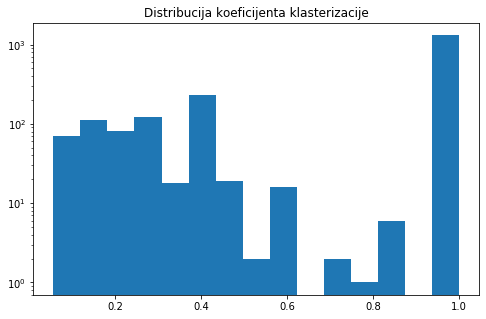

In [18]:
# 10) Koliki je koeficijent klasterizacije mreže i njenih čvorova?
plt.figure(figsize=(8,5)) 
plt.title("Distribucija koeficijenta klasterizacije")
plt.yscale('log')
plt.hist(nx.clustering(actor_graph).values(), 15)

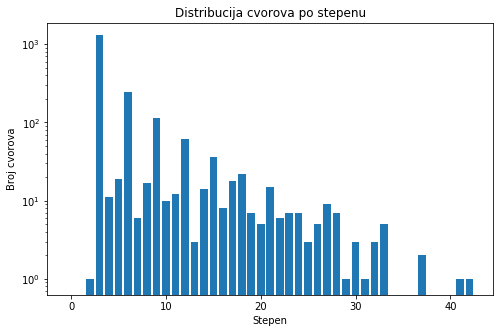

In [19]:
# 11) Kakva je distribucija čvorova po stepenu i da li prati neku zakonomernost?
plt.figure(figsize=(8,5)) 
plt.title("Distribucija cvorova po stepenu")
plt.ylabel("Broj cvorova")
plt.yscale('log')
plt.xlabel("Stepen")
vals = nx.degree_histogram(actor_graph)
plt.bar(range(len(vals)), vals)
plt.show()

In [20]:
# 12) Da li mreža iskazuje osobine malog sveta?
np.log(actor_graph.number_of_nodes())

7.59337419312129

In [21]:
# 13) Kolika je prosečna udaljenost, a kolika maksimalna udaljenost nekog glumca od Kevina Bejkona (Kevin Bacon)?

# infinite since there are disconnected components

# in KB's connected component:
sssplvs = nx.single_source_shortest_path_length(actor_graph, 'Kevin Bacon').values()
print("average distance: ", sum(sssplvs) / len(sssplvs))

for sg in nx.connected_component_subgraphs(actor_graph):
    if 'Kevin Bacon' in sg:
        print("eccentricity: ", nx.eccentricity(sg, 'Kevin Bacon'))

average distance:  3.7695238095238097
eccentricity:  7


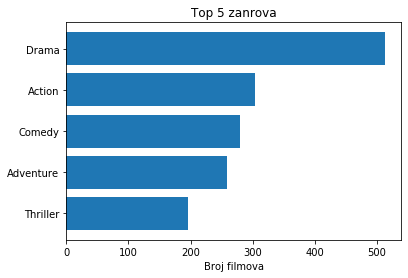

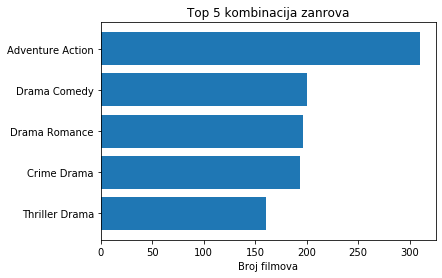

In [22]:
# 15) Koji filmski žanrovi su najpopularniji? U kojim kombinacijama se najčešće javljaju?
genre_count = {}
for genre in genres:
    genre_count[genre] = 0

for _, row in movie_data.iterrows():
    for genre in row.Genre:
        genre_count[genre] += 1        
        genre1 = genre2int[genre]
        for genre2 in [genre2int[x] for x in row.Genre]:
            if genre1 != genre2: # avoid loops
                genre_relation[genre1][genre2] += 1
                
genre_graph = nx.from_numpy_matrix(genre_relation)
int2genre = dict(zip(itertools.count(), genres))
nx.relabel_nodes(genre_graph, int2genre, copy=False)
                
genre_count = sorted(genre_count.items(), key=lambda x: x[1])[-5:]

plt.title('Top 5 zanrova')
plt.xlabel("Broj filmova")
plt.barh([val[0] for val in genre_count], [val[1] for val in genre_count])
plt.show()

genre_comb_count = {}
for edge in genre_graph.edges(data=True):
    genre_comb = edge[0] + ' ' + edge[1]
    if genre_comb not in genre_comb_count:
        genre_comb_count[genre_comb] = 0
        
    genre_comb_count[genre_comb] += edge[2]['weight']

top_genre_combs = sorted(genre_comb_count.items(), key=lambda x: x[1])[-5:]

plt.title('Top 5 kombinacija zanrova')
plt.xlabel("Broj filmova")
plt.barh([val[0] for val in top_genre_combs], [val[1] for val in top_genre_combs])
plt.show()

In [23]:
# 18) Koji režiser je režirao najveći broj filmova?
movie_data.Director.value_counts()[:10]

Ridley Scott          8
David Yates           6
Paul W.S. Anderson    6
M. Night Shyamalan    6
Michael Bay           6
Justin Lin            5
David Fincher         5
Peter Berg            5
Danny Boyle           5
Christopher Nolan     5
Name: Director, dtype: int64

In [24]:
# 19) Da li režiseri imaju omiljene glumce koje često angažuju u svojim filmovima?
def mostFreqActors(movies):
    actors = {}
    
    for index, movie in movies.iterrows():
        for actor in movie.Actors:
            if actor not in actors:
                actors[actor] = 0
            actors[actor] += 1
            
    actors = { k: round(v / float(movies.shape[0])*100, 2) for k, v in actors.items() }
        
    return sorted(actors.items(), key=lambda x: x[1], reverse=True)

directorActors = []
for director in movie_data.Director.value_counts().index:
    movies = movie_data[movie_data['Director'] == director]
    if movies.shape[0] < 3: continue
    
    most_freq_actors = list(filter(lambda x: x[1] >= 80, mostFreqActors(movies)))
    if len(most_freq_actors) > 0:
        actor = most_freq_actors[0][0] + ' (' + str(most_freq_actors[0][1]) + '%)'
        directorActors.append((director, len(movies), actor))
#         print director
#         for item in most_freq_actors:
#             print str(item[1])+'%', '\t', item[0]
#         print ''
        
pd.DataFrame(np.array(directorActors).reshape(len(directorActors),3), columns = ['Director', 'Num. of movies', 'Most freq. casted actor'])

,Director,Num. of movies,Most freq. casted actor
0,Dennis Dugan,4,Adam Sandler (100.0%)
1,Lars von Trier,4,Charlotte Gainsbourg (100.0%)
2,Ethan Coen,3,Josh Brolin (100.0%)
3,Neill Blomkamp,3,Sharlto Copley (100.0%)
4,Seth MacFarlane,3,Seth MacFarlane (100.0%)
5,Ben Stiller,3,Ben Stiller (100.0%)
6,Sylvester Stallone,3,Sylvester Stallone (100.0%)


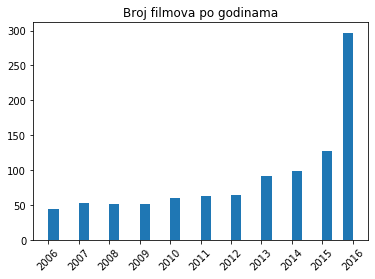

In [25]:
# 20) Koje godine je filmska produkcija bila najveća?
# print sorted(zip(years.keys(), [len(m) for m in years.values()]), reverse=True)
plt.title("Broj filmova po godinama")
plt.xticks(range(2006,2017),rotation=45)
plt.hist(movie_data.Year,30)
plt.show()

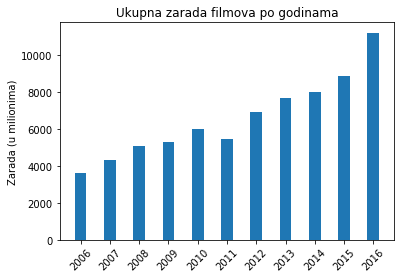

In [26]:
plt.title("Ukupna zarada filmova po godinama")
plt.xticks(range(2006,2017),rotation=45)
plt.ylabel("Zarada (u milionima)")
plt.bar(range(2006,2017), movie_data.groupby(['Year'])['Revenue (Millions)'].sum(),0.4)
plt.show()

(array([612., 152.,  57.,  33.,  11.,   3.,   2.,   0.,   1.,   1.]),
 array([  0.   ,  93.663, 187.326, 280.989, 374.652, 468.315, 561.978,
        655.641, 749.304, 842.967, 936.63 ]),
 <a list of 10 Patch objects>)

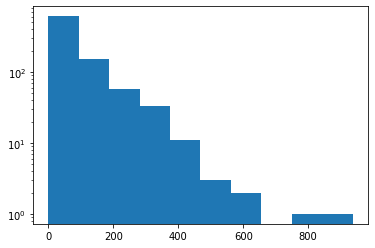

In [27]:
plt.yscale('log')
plt.hist(movie_data['Revenue (Millions)'].dropna())